# CS 477 HW 6: Gradient Descent on MLPs
## Chris Tralie

This is a simple test to make sure our neural network engine is able to separate the inside of a circle from the outside, which would not work with logistic regression over the two dimensions

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import IPython.display as ipd
from mlp import *
from layers import *
from losses import *

First, let's generate the data

Text(0.5, 1.0, 'Intial Disc Data')

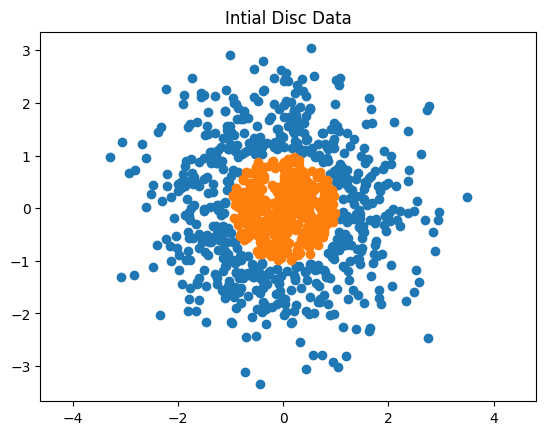

In [2]:
def get_disc_points(N):
    X = np.random.randn(N, 2)
    d = np.sqrt(np.sum(X**2, axis=1))
    ys = np.array(d < 1, dtype=float)
    X[ys == 0, :] *= 1.1 # Put a small gap between inner and outer points
    return X, ys

np.random.seed(0)
X, ys = get_disc_points(1000)
plt.scatter(X[ys==0, 0], X[ys==0, 1])
plt.scatter(X[ys==1, 0], X[ys==1, 1])
plt.axis("equal")
plt.title("Intial Disc Data")

Now let's setup a neural network and train it!  We'll put 100 neurons in the first hidden layer, followed by 2 neurons, followed by a single neuron with the logistic activation.  Since the last hidden layer has 2 neurons, we can the coordinates on the data mapped through it to see how well it's being separated

Epoch 0 Loss [675.70343765] Accuracy 0.593


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

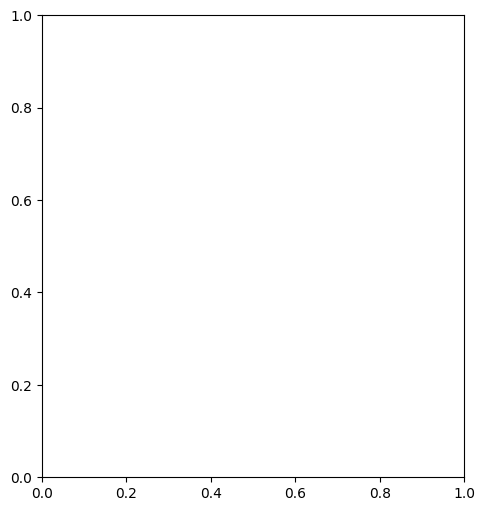

In [4]:
plot_animation=True
np.random.seed(0)

nn = MLP(2, logistic_est_loss_deriv) # Input is in 2 dimensions, and we want to use logistic loss
nn.add_layer(100,  leaky_relu, leaky_relu_deriv, name="layer1") # First layer is 100 dimensions with a leaky ReLU
nn.add_layer(2, leaky_relu, leaky_relu_deriv, name="layer2") # Second layer is 2 dimensions with a leaky ReLU
nn.add_layer(1, logistic, None, name="lastlayer") # Last layer is the logistic function.  Its derivative is handled separately

n_epochs = 100
alpha = 0.001
losses = []

fig = plt.figure(figsize=(12, 6))
frames = []
for epoch in range(n_epochs):
    loss = 0
    num_correct = 0
    X1 = []
    X2 = []
    for k in range(X.shape[0]):
        y_est = nn.forward(X[k, :])
        num_correct += (np.round(y_est) == ys[k])
        loss += logistic_est_loss(y_est, ys[k])
        xy = nn.forward(X[k, :], end="layer2")
        if ys[k] == 0:
            X1.append(xy)
        else:
            X2.append(xy)
    print("Epoch {} Loss {} Accuracy {}".format(epoch, loss, num_correct[0]/X.shape[0]))
    losses.append(loss)
    X1 = np.array(X1)
    X2 = np.array(X2)

    # Plot Result
    # Get the 2D linear separator from the weights/bias in the last layer
    ##a, b = nn.layers[-1]["W"].flatten() 
    ##c = nn.layers[-1]["b"][0]
    plt.subplot(121)
    #print(X1[1].size)
    plot = [plt.scatter(X1[:, 0], X1[:, 1], c='C0')]
    plot += [plt.scatter(X2[:, 0], X2[:, 1], c='C1')]
    plt.gca().set_facecolor("white")
    plot.append(plt.text(0.5, 1.01, "Epoch {} Accuracy {:.3f}".format(epoch, num_correct[0]/X.shape[0]),
                        horizontalalignment='center', verticalalignment='bottom',
                        transform=plt.gca().transAxes, size='xx-large'))
    
    plt.subplot(122)
    plot += plt.plot(losses, c='C0')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xlim([0, n_epochs])
    plt.ylim([0, np.max(losses)])
    plot.append(plt.text(0.5, 1.01, "Loss {:.3f}".format(loss[0]),
                        horizontalalignment='center', verticalalignment='bottom',
                        transform=plt.gca().transAxes, size='xx-large'))
    plt.gca().set_facecolor("white")
    frames.append(plot)
    
    # Stochastic gradient descent
    for k in np.random.permutation(X.shape[0]):
        nn.backward(X[k, :], ys[k])
        nn.step(alpha)
        nn.zero_grad()

ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat_delay=1000)
ani.save("result.gif", dpi=200)
